In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import PreShapeSpace
from geomstats.visualization import KendallSphere

import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere


import numpy as np

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.learning import kmeans as km
from scipy.stats import multivariate_normal
import ot


INFO: Using numpy backend


In [2]:
# import numpy as np

# from geomstats.learning.frechet_mean import FrechetMean
# from geomstats.learning.pca import TangentPCA
# from geomstats.learning import kmeans as km
# from scipy.stats import multivariate_normal
# import ot

# def plot_triangle(point, **kwargs):
#     point = np.vstack((point,point[0]))
#     plt.plot(point[:,0],point[:,1],**kwargs)
    
    
# def random_wrapped_gaussian(space, mu, Sigma, N, reference_point=None, reference_frame=None):
#     W = np.random.multivariate_normal(np.zeros(space.dim),Sigma,N)    
#     if reference_frame==None:
#         reference_point, reference_frame = random_tangent_basis(space,mu)    
#     if len(reference_frame.shape)==2:
#         Y = np.matmul(W,reference_frame)
#     elif len(reference_frame.shape)==3:
#         Y = np.transpose(np.matmul(np.transpose(reference_frame,[1,2,0]),W.T),[2,0,1])
#     Z = space.metric.parallel_transport(Y, reference_point, end_point=mu)
#     return space.metric.exp(Z,mu)


# def random_tangent_basis(space,mu):
#     dim = mu.shape

#     # Generate random points in space for tangent space pca
#     N = space.dim+1
#     points = space.random_point(N)

#     # Fit tangent space pca in tangent space at reference point to randomly generated points to get orthonormal basis for tangent space at reference point
#     tpca = TangentPCA(space, n_components=dim[0])
#     tpca.fit(points, base_point=mu)
#     #only keep components with non-zero singular values - important for EM
#     keep_ind=tpca.explained_variance_ratio_>1e-14 

#     #Initialize reference frame - reshape tpca output if needed
#     if len(dim)==1:
#         random_tangent_basis = space.metric.log(tpca.components_[keep_ind],mu)
#     elif len(dim)==2:
#         random_tangent_basis = space.metric.log(tpca.components_[keep_ind].reshape((dim[0],dim[0],dim[1])),mu)
        
#     return mu, random_tangent_basis



# class WrappedGaussianMixture():
    
#     def __init__(self, space, n_components=1, reference_point=None):
#         self.space = space
#         self.dim = space.dim
#         self.n_components = n_components
#         self.reference_point = reference_point
        
#         self.init_moving_frame()
        
#     def init_moving_frame(self):

#         # Initialize reference_point  
#         if self.reference_point==None:
#             self.reference_point = self.space.random_point(1)

#         # Get shape of points in space, for reshaping (tpca flattens)
#         dim = self.reference_point.shape

#         # Generate random points in space for tangent space pca
#         N = self.dim+1
#         points = self.space.random_uniform(N)
        
#         # Fit tangent space pca in tangent space at reference point to randomly generated points to get orthonormal basis for tangent space at reference point
#         tpca = TangentPCA(self.space, n_components=dim[0])
#         tpca.fit(points, base_point=self.reference_point)
#         #only keep components with non-zero singular values - important for EM
#         keep_ind=tpca.explained_variance_ratio_>1e-14 
        
#         #Initialize reference frame - reshape tpca output if needed
#         if len(dim)==1:
#             self.reference_frame = self.space.metric.log(tpca.components_[keep_ind],self.reference_point)
#         elif len(dim)==2:
#             self.reference_frame = self.space.metric.log(tpca.components_[keep_ind].reshape((dim[0],dim[0],dim[1])),self.reference_point)            
            
#     def fit(self, X):
#         # There may be a better way to access this parameter 
#         d = np.prod(X.shape[1:])
        
#         mean = FrechetMean(self.space)
#         kmeans = km.RiemannianKMeans(self.space, n_clusters=self.n_components)
#         idx = kmeans.fit(X).labels_
        
#         w_hat=[]
#         mu_hat=[]
#         Sigma_hat=[]

#         #estimate parameters for each cluster
#         for i in range(self.n_components):
#             #get mixing parameter
#             w_hat = np.sum(idx==i)/idx.shape[0]
#             #get data for cluster
#             component = X[idx==i]
#             #estimate frechet mean for cluster
#             mu_hat.append(mean.fit(component).estimate_)
#             #parallel transport reference frame to estimated mean, flatten, to calculate covariance
#             F_ref_t = self.space.metric.parallel_transport(self.reference_frame,self.reference_point,end_point=mu_hat[-1]).reshape(self.reference_frame.shape[0],d)
#             #Log map cluster into tangent space at mu_hat
#             V=(self.space.metric.log(component,base_point=mu_hat[-1]).reshape(sum(idx==i),d))
#             #Project log mapped cluster into moving frame, calculate covariance
#             Sigma_hat.append(np.cov(F_ref_t@V.T))#if F_ref is a x b and V is b x N, then Sigma_hat is a x a (np.cov(X) = XX^t/(N-1))
            
#         self.labels_ = idx
#         self.weights_ = [sum(idx==i)/len(idx) for i in np.unique(idx)]  
#         self.means_ = mu_hat
#         self.covariances_ = Sigma_hat
  


In [3]:
def random_tangent_basis(space,mu):
    dim = mu.shape

    # Generate random points in space for tangent space pca
    N = space.dim+1
    points = space.random_point(N)

    # Fit tangent space pca in tangent space at reference point to randomly generated points to get orthonormal basis for tangent space at reference point
    tpca = TangentPCA(space, n_components=dim[0])
    tpca.fit(points, base_point=mu)
    #only keep components with non-zero singular values - important for EM
    keep_ind=tpca.explained_variance_ratio_>1e-14 

    #Initialize reference frame - reshape tpca output if needed
    if len(dim)==1:
        random_tangent_basis = space.metric.log(tpca.components_[keep_ind],mu)
    elif len(dim)==2:
        random_tangent_basis = space.metric.log(tpca.components_[keep_ind].reshape((dim[0],dim[0],dim[1])),mu)
        
    return random_tangent_basis


def random_wrapped_gaussian(space, mu, Sigma, N, reference_point=None, reference_frame=None):
    #generate 
    W = np.random.multivariate_normal(np.zeros(space.dim),Sigma,N)    
    if reference_frame==None:
        reference_point = space.random_point()
        reference_frame = random_tangent_basis(space,reference_point)    
    if len(reference_frame.shape)==2:
        Y = np.matmul(W,reference_frame)
    elif len(reference_frame.shape)==3:
        Y = np.transpose(np.matmul(np.transpose(reference_frame,[1,2,0]),W.T),[2,0,1])
    Z = space.metric.parallel_transport(Y, reference_point, end_point=mu)
    return space.metric.exp(Z,mu)

def random_wrapped_gaussian_mixture(space, means, covariances, weights, N = 200):   
        return np.vstack([random_wrapped_gaussian(sphere, means[k], covariances[k], int(weights[k]*N)) for k in range(len(means))])
    

def plot_tangent_vecs(mu,F,scale=.4,cmap=['red','blue'],**kwargs):
    
    for i, t in enumerate(F):
        data = np.vstack((mu,mu+scale*t))
        plt.plot(data[:,0],data[:,1],data[:,2], c=cmap[i], **kwargs)
        

        
        
class WrappedGaussianMixture():
    
    def __init__(self, space, n_components=1, reference_point=None, reference_frame=None):
        self.space = space
        self.dim = space.dim
        self.n_components = n_components
        self.reference_point = reference_point
        self.reference_frame = reference_frame
        
        self.init_moving_frame()
        
    def init_moving_frame(self):

        # Initialize reference_point  
        if self.reference_point is None:
            self.reference_point = self.space.random_point(1)

            # Get shape of points in space, for reshaping (tpca flattens)
            dim = self.reference_point.shape

            # Generate random points in space for tangent space pca
            N = self.dim+1
            points = self.space.random_uniform(N)

            # Fit tangent space pca in tangent space at reference point to randomly generated points to get orthonormal basis for tangent space at reference point
            tpca = TangentPCA(self.space, n_components=dim[0])
            tpca.fit(points, base_point=self.reference_point)
            #only keep components with non-zero singular values - important for EM
            keep_ind=tpca.explained_variance_ratio_>1e-14 

            #Initialize reference frame - reshape tpca output if needed
            if len(dim)==1:
                self.reference_frame = self.space.metric.log(tpca.components_[keep_ind],self.reference_point)
            elif len(dim)==2:
                self.reference_frame = self.space.metric.log(tpca.components_[keep_ind].reshape((dim[0],dim[0],dim[1])),self.reference_point)         
                
        elif self.reference_frame is None:
            
            # Get shape of points in space, for reshaping (tpca flattens)
            dim = self.reference_point.shape

            # Generate random points in space for tangent space pca
            N = self.dim+1
            points = self.space.random_uniform(N)

            # Fit tangent space pca in tangent space at reference point to randomly generated points to get orthonormal basis for tangent space at reference point
            tpca = TangentPCA(self.space, n_components=dim[0])
            tpca.fit(points, base_point=self.reference_point)
            #only keep components with non-zero singular values - important for EM
            keep_ind=tpca.explained_variance_ratio_>1e-14 

            #Initialize reference frame - reshape tpca output if needed
            if len(dim)==1:
                self.reference_frame = self.space.metric.log(tpca.components_[keep_ind],self.reference_point)
            elif len(dim)==2:
                self.reference_frame = self.space.metric.log(tpca.components_[keep_ind].reshape((dim[0],dim[0],dim[1])),self.reference_point)     
                
        self.reference_frame = np.array([f/np.linalg.norm(f) for f in self.reference_frame])
            
    def fit(self, X):
        # There may be a better way to access this parameter 
        d = np.prod(X.shape[1:])
        
        mean = FrechetMean(self.space)
        kmeans = km.RiemannianKMeans(self.space, n_clusters=self.n_components)
        idx = kmeans.fit(X).labels_
        
        w_hat=[]
        mu_hat=[]
        Sigma_hat=[]

        #estimate parameters for each cluster
        for i in range(self.n_components):
            #get mixing parameter
            w_hat = np.sum(idx==i)/idx.shape[0]
            #get data for cluster
            component = X[idx==i]
            #estimate frechet mean for cluster
            mu_hat.append(mean.fit(component).estimate_)
            #parallel transport reference frame to estimated mean, flatten, to calculate covariance
            F_ref_t = self.space.metric.parallel_transport(self.reference_frame,self.reference_point,end_point=mu_hat[-1]).reshape(self.reference_frame.shape[0],d)
            #Log map cluster into tangent space at mu_hat
            V=(self.space.metric.log(component,base_point=mu_hat[-1]).reshape(sum(idx==i),d))
            #Project log mapped cluster into moving frame, calculate covariance
            Sigma_hat.append(np.cov(F_ref_t@V.T))#if F_ref is a x b and V is b x N, then Sigma_hat is a x a (np.cov(X) = XX^t/(N-1))
            
        self.labels_ = idx
        self.weights_ = [sum(idx==i)/len(idx) for i in np.unique(idx)]  
        self.means_ = mu_hat
        self.covariances_ = Sigma_hat
        
        
        
        
        
        
def wasserstein_type_distance(mu0,mu1):
    if mu0.space==mu1.space:
        space = mu0.space

        d_M=np.zeros((mu0.n_components,mu1.n_components))
        d_B=np.zeros((mu0.n_components,mu1.n_components))

        for i in range(mu0.n_components):
            (m0,sigma0)= (mu0.means_[i],mu0.covariances_[i])
            for j in range(mu1.n_components):
                (m1,sigma1)= (mu1.means_[j],mu1.covariances_[j])

                # #normalize just to make sure - generally ~0.99999
                # print(np.linalg.norm(m0))
                # print(np.linalg.norm(m1))
                m0=m0/np.linalg.norm(m0)
                m1=m1/np.linalg.norm(m1)

                d_M[i,j] = space.metric.dist(m0,m1)

                # #use svd to calculate square roots - no issues with complex values
                u0,s0,v0 = np.linalg.svd(sigma0)
                sqrt_sigma0 = u0@np.diag(np.sqrt(s0))@u0.T
                cross_term = sqrt_sigma0 @ sigma1 @ sqrt_sigma0
                u2,s2,v2 = np.linalg.svd(cross_term)
                sqrt_cross_term = u2@np.diag(np.sqrt(s2))@v2

                d_B[i,j] = np.trace(sigma0 + sigma1 -2*sqrt_cross_term)
                # d_B[i,j] = np.real(np.trace(sigma0 + sigma1 -2*scipy.linalg.sqrtm(scipy.linalg.sqrtm(sigma0) + sigma1 + scipy.linalg.sqrtm(sigma0))))

        M = d_M**2 + d_B 
    
        return ot.emd(mu0.weights_,mu1.weights_,M), M#, ot.emd2(mu0.weights,mu1.weights,d_M**2), ot.emd2(mu0.weights,mu1.weights,d_B)

    else:
        print("error: spaces don't match")
    
    
def hopf_fibration(S, phi_2 = 0, center=True):
    #initialize array for triangles
    T = np.zeros((S.shape[0],3,2)) 
    
    for i, s in enumerate(S):
                 
        #convert s \in S^2 to sphereical coordinates
        (x,y,z) = s
        rho = np.linalg.norm(s)
        theta = np.arccos(z/rho)
        phi_1 = np.arctan(y/x)
        
        #Hopf fibration
        x1 = np.cos((phi_2 + phi_1)/2)*np.sin(theta/2) 
        x2 = np.sin((phi_2 + phi_1)/2)*np.sin(theta/2)
        x3 = np.cos((phi_2 - phi_1)/2)*np.cos(theta/2)
        x4 = np.sin((phi_2 - phi_1)/2)*np.cos(theta/2)
        
        
        t = np.array([[0,0],[x1,x2],[x3,x4]])
        
        if center:
            T[i] = t - np.mean(t,0)
        else:
            T[i] = t
    
    return T


def plot_triangle(point, **kwargs):
    point = np.vstack((point,point[0]))
    plt.plot(point[:,0],point[:,1],**kwargs)

In [4]:
# \printinunitsof{in}\prntlen{\textwidth}
# 6.50127in

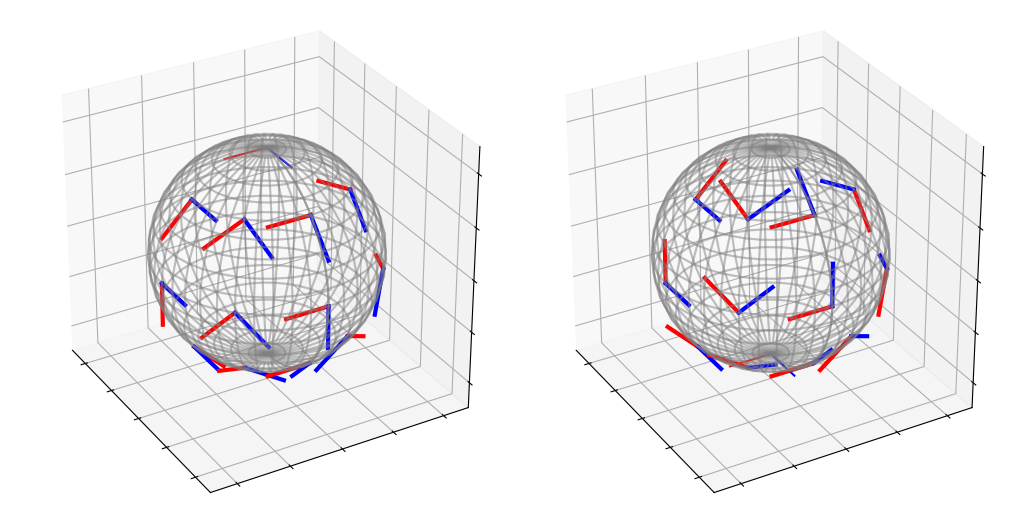

In [45]:
#define space
sphere = Hypersphere(2)

#define moving frame
mu = np.array([0,0,1])
F = np.array([[0,-1,0],[1,0,0]])

#get set of points at which to plot moving frame
X=[]

theta = np.arange(-2,2)*np.pi/4
phi = np.arange(-2,1)*np.pi/2
for t in theta:
    for p in phi:        
        x=[np.cos(t),np.sin(t),np.cos(p)]
        X.append(x/np.linalg.norm(x))


#plot
%matplotlib inline
fig = plt.figure(figsize=(2*6.5,2*3.25))

ax = fig.add_subplot(121, projection='3d')

visualization.plot(mu, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")
visualization.plot(mu, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")
visualization.plot(mu, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")
plot_tangent_vecs(mu,F)
for x in X:
    plot_tangent_vecs(x,sphere.metric.parallel_transport(F,mu, end_point=x), linewidth=3) 

ax.tick_params(axis='both', which='major', labelsize=8)
ax.view_init(azim=330)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.savefig("data_files/images2/orthogonal_frames_illustration_0.png",dpi=216,bbox_inches='tight')



# fig = plt.figure(figsize=(2*6.5,2*3.25))

ax = fig.add_subplot(122, projection='3d')

visualization.plot(-mu, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")
visualization.plot(-mu, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")
visualization.plot(-mu, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")
plot_tangent_vecs(-mu,F)

for x in X:
    plot_tangent_vecs(x,sphere.metric.parallel_transport(F,-mu, end_point=x), linewidth=3) 
  
ax.tick_params(axis='both', which='major', labelsize=8)
ax.view_init(azim=330)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("data_files/images2/orthogonal_frames_illustration_1.png",dpi=216,bbox_inches='tight')
# plt.show()

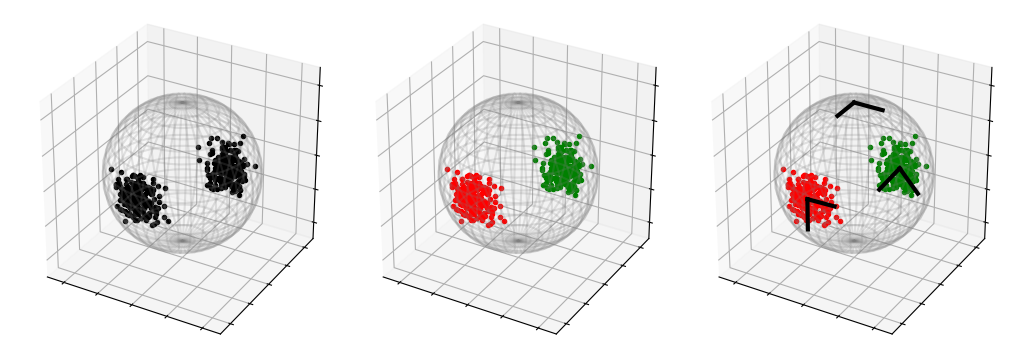

In [44]:
from geomstats.learning import frechet_mean

K=2
cmap = ['red','green','blue']

#define space
sphere = Hypersphere(2)
mean = FrechetMean(sphere)

#generate random points in space
a=np.array([ 1,-.4,.6])
b=np.array([ -.1,-1,.1])
mu_list = [a/np.linalg.norm(a),b/np.linalg.norm(b)]

#generate sample from random wrapped Gaussian
X = np.vstack([random_wrapped_gaussian(sphere, mu_list[k], np.eye(sphere.dim)/100,200) for k in range(K)])

#define moving frame
mu = np.array([0,0,1])
F = np.array([[0,-1,0],[1,0,0]])

#plot
fig = plt.figure(figsize=(2*6.5,2*3.25))

ax = fig.add_subplot(131,projection='3d')
visualization.plot(X, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")

plt.plot(X[:,0],X[:,1],X[:,2],'.', c='black')

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# plt.show()
plt.savefig("data_files/images2/parameter_estimation_0", dpi=216, bbox_inches='tight')


kmeans = km.RiemannianKMeans(sphere, n_clusters=2)
idx = kmeans.fit(X).labels_

#plot
# fig = plt.figure(figsize=(6.5,3.25))

ax = fig.add_subplot(132,projection='3d')
visualization.plot(X, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")

for i,x in enumerate(X):
    plt.plot(x[0],x[1],x[2],'.', c=cmap[idx[i]])
    
    
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# plt.show()
plt.savefig("data_files/images2/parameter_estimation_1", dpi=216, bbox_inches='tight')




#plot
# fig = plt.figure(figsize=(6.5,6.5))

ax = fig.add_subplot(133,projection='3d')
visualization.plot(X, ax = ax, space="S2", color="black", alpha=0.0, label="Data points")

for i,x in enumerate(X):
    plt.plot(x[0],x[1],x[2],'.', c=cmap[idx[i]])
  

plot_tangent_vecs(mu,F, cmap=['black']*2,linewidth=3,zorder=10)

for k in np.unique(idx):
    mu_x = mean.fit(X[idx==k]).estimate_
    F_mu_x = sphere.metric.parallel_transport(F,mu,end_point=mu_x)
    plot_tangent_vecs(mu_x,F_mu_x, cmap=['black']*2,linewidth=3,zorder=10)
    
    
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.subplots_adjust(wspace=0)#, hspace=0)


# plt.show()
plt.savefig("data_files/images2/parameter_estimation", dpi=216, bbox_inches='tight')

In [7]:
##Weights for gmm00
weights_00 = np.array([25,25,50])/100

##Means for gmm00
m0=np.array([ 1,-.3,.9])
m1=np.array([ -.1,-1,.3])
m2=np.array([ 1,-.6,-.3])

means_00 = [m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm00
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,4])/150

covariances_00 = [c0,c1,c2]

X0 = random_wrapped_gaussian_mixture(sphere, means_00, covariances_00, weights_00)


##Weights for gmm01
weights_01 = np.array([33,33,34])/100

##Means for gmm01
m0=np.array([ 1,-.3,.3])
m1=np.array([ -.1,-1,-.3])
m2=np.array([ -.1,-1,.9])

means_01 = [m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm01
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,3])/150

covariances_01 = [c0,c1,c2]

X1 = random_wrapped_gaussian_mixture(sphere, means_01, covariances_01, weights_01)


# fig = plt.figure(figsize=(2*6.5,2*6.5))
# ax_1 = fig.add_subplot(221, projection='3d')
# visualization.plot(X0, ax = ax_1, space="S2", color="red", alpha=1, label="Data points")
# visualization.plot(X1, ax = ax_1, space="S2", color="blue", alpha=1, label="Data points")

##Weights for gmm10
weights_10 = np.array([25,25,50])/100

##Means for gmm10
m0=np.array([ 1,-.3,.9])
m1=np.array([ -.1,-1,.3])
m2=np.array([ 1,-.6,-.3])

means_10 = [m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm10
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,4])/150

covariances_10 = [c0,c1,c2]

X2 = random_wrapped_gaussian_mixture(sphere, means_00, covariances_00, weights_00)


##Weights for gmm11
weights_11 = np.array([33,33,34])/100

##Means for gmm11
m0=np.array([ 1,-.3,.3])
m1=np.array([ -.1,-1,-.3])
m2=np.array([ -.1,-1,.9])

means_11 = means_10

##Covariances for gm11
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,3])/150

covariances_11 = covariances_10

X3 = random_wrapped_gaussian_mixture(sphere, means_11, covariances_11, weights_01)

# fig = plt.figure(figsize=(2*6.5,2*6.5))
# ax_1 = fig.add_subplot(221, projection='3d')
# visualization.plot(X2, ax = ax_1, space="S2", color="red", alpha=1, label="Data points")
# visualization.plot(X3, ax = ax_1, space="S2", color="blue", alpha=1, label="Data points")


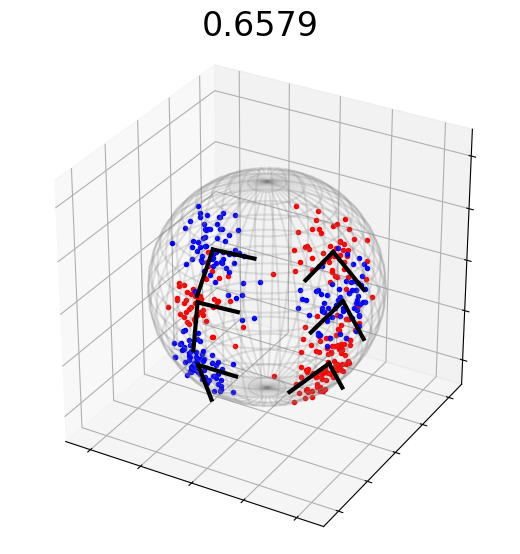

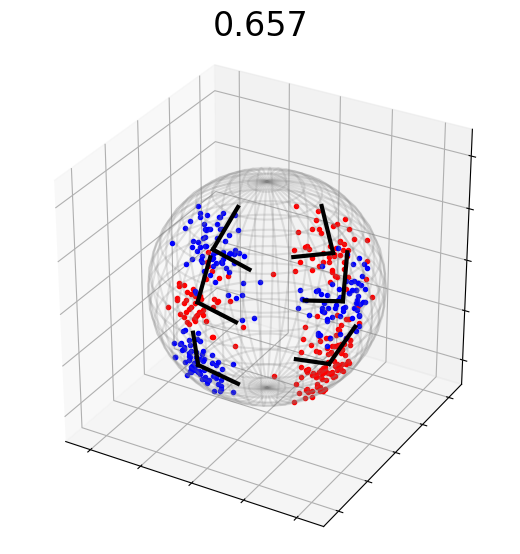

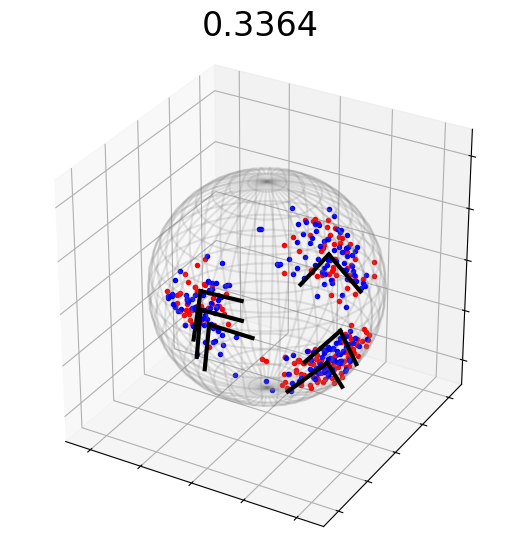

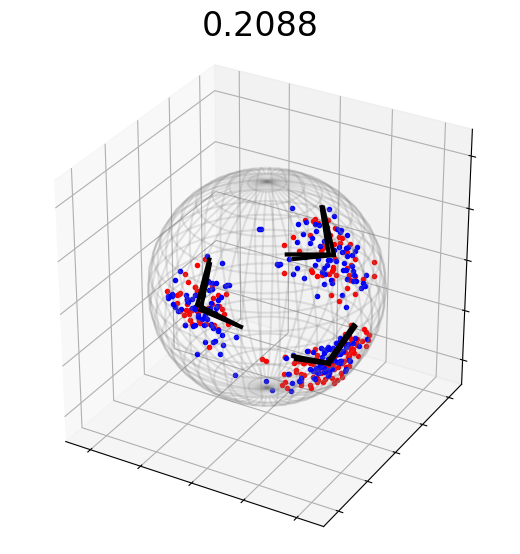

In [8]:
p=np.array([0,0,1])
F = np.array([[0,-1,0],[1,0,0]])

#Define and fit gmm model to X0
gmm0=WrappedGaussianMixture(sphere, n_components=3, reference_point=p, reference_frame=F)
gmm0.fit(X0)

#Define and fit gmm model to X1
gmm1=WrappedGaussianMixture(sphere, n_components=3, reference_point=p, reference_frame=F)
gmm1.fit(X1)

#plot
fig = plt.figure(figsize=(6.5,6.5))
ax_1 = fig.add_subplot(projection='3d')

visualization.plot(p, ax = ax_1, space="S2", color="black", alpha=0.0, label="Data points")
plt.plot(X0[:,0],X0[:,1],X0[:,2],'.',c='red')
plt.plot(X1[:,0],X1[:,1],X1[:,2],'.',c='blue')

for sample_mean in gmm0.means_:
    F_mu_x = sphere.metric.parallel_transport(F,p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)

for sample_mean in gmm1.means_:
    F_mu_x = sphere.metric.parallel_transport(F,p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)
    
    
Pi,M = wasserstein_type_distance(gmm0,gmm1)   

ax_1.set_xlabel(None)
ax_1.set_ylabel(None)
ax_1.set_zlabel(None)
ax_1.set_xticklabels([])
ax_1.set_yticklabels([])
ax_1.set_zticklabels([])
plt.title(round(np.sum(Pi*M),4), fontsize=24)
plt.savefig("data_files/images2/experiment_2_00.png", dpi=216, bbox_inches='tight')


#Define and fit gmm model to X0
gmm0=WrappedGaussianMixture(sphere, n_components=3, reference_point=-p, reference_frame=F)
gmm0.fit(X0)


#Define and fit gmm model to X1
gmm1=WrappedGaussianMixture(sphere, n_components=3, reference_point=-p, reference_frame=F)
gmm1.fit(X1)

#plot
fig = plt.figure(figsize=(6.5,6.5))
ax_2 = fig.add_subplot(projection='3d')

visualization.plot(p, ax = ax_2, space="S2", color="black", alpha=0.0, label="Data points")
plt.plot(X0[:,0],X0[:,1],X0[:,2],'.',c='red')
plt.plot(X1[:,0],X1[:,1],X1[:,2],'.',c='blue')

for sample_mean in gmm0.means_:
    F_mu_x = sphere.metric.parallel_transport(F,-p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)

for sample_mean in gmm1.means_:
    F_mu_x = sphere.metric.parallel_transport(F,-p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)
    
ax_2.set_xlabel(None)
ax_2.set_ylabel(None)
ax_2.set_zlabel(None)
ax_2.set_xticklabels([])
ax_2.set_yticklabels([])
ax_2.set_zticklabels([])

Pi,M = wasserstein_type_distance(gmm0,gmm1)    
plt.title(round(np.sum(Pi*M),4), fontsize=24)
plt.savefig("data_files/images2/experiment_2_01.png", dpi=216, bbox_inches='tight')








p=np.array([0,0,1])
F = np.array([[0,-1,0],[1,0,0]])

#Define and fit gmm model to X0
gmm2=WrappedGaussianMixture(sphere, n_components=3, reference_point=p, reference_frame=F)
gmm2.fit(X2)

#Define and fit gmm model to X1
gmm3=WrappedGaussianMixture(sphere, n_components=3, reference_point=p, reference_frame=F)
gmm3.fit(X3)

#plot
fig = plt.figure(figsize=(6.5,6.5))
ax_3 = fig.add_subplot(projection='3d')

visualization.plot(p, ax = ax_3, space="S2", color="black", alpha=0.0, label="Data points")
plt.plot(X2[:,0],X2[:,1],X2[:,2],'.',c='red')
plt.plot(X3[:,0],X3[:,1],X3[:,2],'.',c='blue')

for sample_mean in gmm2.means_:
    F_mu_x = sphere.metric.parallel_transport(F,p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)

for sample_mean in gmm3.means_:
    F_mu_x = sphere.metric.parallel_transport(F,p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)
    
    
Pi,M = wasserstein_type_distance(gmm2,gmm3)   

ax_3.set_xlabel(None)
ax_3.set_ylabel(None)
ax_3.set_zlabel(None)
ax_3.set_xticklabels([])
ax_3.set_yticklabels([])
ax_3.set_zticklabels([])

plt.title(round(np.sum(Pi*M),4), fontsize=24)
plt.savefig("data_files/images2/experiment_2_10.png", dpi=216, bbox_inches='tight')


#Define and fit gmm model to X0
gmm2=WrappedGaussianMixture(sphere, n_components=3, reference_point=-p, reference_frame=F)
gmm2.fit(X2)

#Define and fit gmm model to X1
gmm3=WrappedGaussianMixture(sphere, n_components=3, reference_point=-p, reference_frame=F)
gmm3.fit(X3)

#plot
fig = plt.figure(figsize=(6.5,6.5))
ax_4 = fig.add_subplot(projection='3d')

visualization.plot(p, ax = ax_4, space="S2", color="black", alpha=0.0, label="Data points")
plt.plot(X2[:,0],X2[:,1],X2[:,2],'.',c='red')
plt.plot(X3[:,0],X3[:,1],X3[:,2],'.',c='blue')

for sample_mean in gmm2.means_:
    F_mu_x = sphere.metric.parallel_transport(F,-p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)

for sample_mean in gmm3.means_:
    F_mu_x = sphere.metric.parallel_transport(F,-p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)
    
ax_4.set_xlabel(None)
ax_4.set_ylabel(None)
ax_4.set_zlabel(None)
ax_4.set_xticklabels([])
ax_4.set_yticklabels([])
ax_4.set_zticklabels([])
# ax_4.tick_params(axis='both', which='major', labelsize=8)

Pi,M = wasserstein_type_distance(gmm2,gmm3)    
plt.title(round(np.sum(Pi*M),4), fontsize=24)


plt.subplots_adjust(wspace=0, hspace=.05)

# plt.show()
plt.savefig("data_files/images2/experiment_2_11.png", dpi=216, bbox_inches='tight')

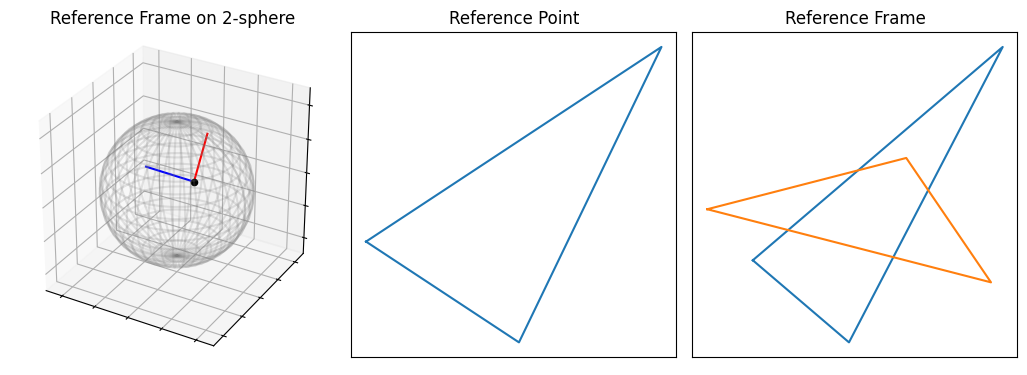

In [46]:
#plot
# fig = plt.figure(figsize=(3*6.5,6.5))

p = np.array([1/np.sqrt(3),-1/np.sqrt(3),1/np.sqrt(3)])
F = random_tangent_basis(sphere,p) 

fig = plt.figure(figsize=(2*6.5,2*3.25))
ax = fig.add_subplot(131,projection='3d')
visualization.plot(p, ax = ax, space="S2", color="black", alpha=1, label="Data points")
plot_tangent_vecs(p,F)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.title("Reference Frame on 2-sphere")#, fontsize=21)

# plt.savefig("data_files/images2/triangles_reference_frame_0.png", dpi=216, bbox_inches='tight')

# fig = plt.figure(figsize=(6.5,6.5))
plt.subplot(132)
reference_triangle = hopf_fibration(np.array([p]))[0]
plot_triangle(reference_triangle)
plt.xticks([])
plt.yticks([])
plt.gca().set_box_aspect(1)
plt.title("Reference Point")#, fontsize=24)

# plt.savefig("data_files/images2/triangles_reference_frame_1.png", dpi=216, bbox_inches='tight')

# fig = plt.figure(figsize=(6.5,6.5))
plt.subplot(133)
reference_triangle_basis=[]
for f in F:
    reference_triangle_basis.append(hopf_fibration(np.array([f]))[0])
    plot_triangle(reference_triangle_basis[-1])
plt.xticks([])
plt.yticks([])
plt.gca().set_box_aspect(1)
plt.title("Reference Frame")#, fontsize=24)

plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig("data_files/images2/triangles_reference_frame.png", dpi=216, bbox_inches='tight')

In [48]:
m_ambient = 2
k_landmarks = 3
K=3

preshape_triangle_2d = PreShapeSpace(k_landmarks,m_ambient)
preshape_triangle_2d.equip_with_group_action("rotations")
preshape_triangle_2d.equip_with_quotient_structure()

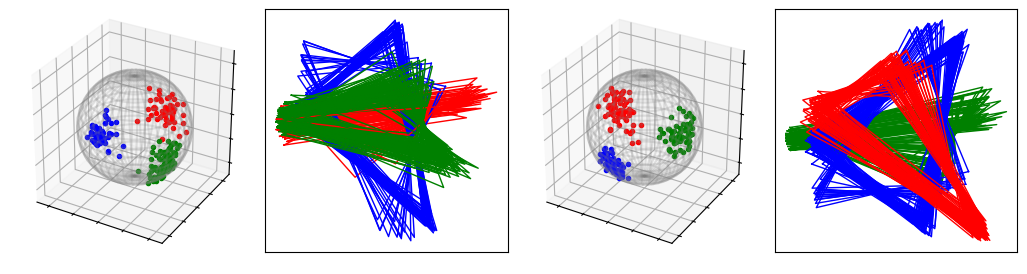

In [57]:


fig = plt.figure(figsize=(2*6.5,2*3.25))
ax_1 = fig.add_subplot(141,projection='3d')

visualization.plot(p, ax = ax_1, space="S2", color="black", alpha=0.0, label="Data points")

gmm0.fit(X0)
for i, x in enumerate(X0):
    plt.plot(x[0],x[1],x[2],'.', c = cmap[gmm0.labels_[i]])

ax_1.set_xlabel(None)
ax_1.set_ylabel(None)
ax_1.set_zlabel(None)
ax_1.set_xticklabels([])
ax_1.set_yticklabels([])
ax_1.set_zticklabels([])
# plt.savefig("data_files/images2/experiment_3_0.png", dpi=216, bbox_inches='tight')




# fig = plt.figure(figsize=(6.5,6.5))
ax_1 = fig.add_subplot(143,projection='3d')

visualization.plot(p, ax = ax_1, space="S2", color="black", alpha=0.0, label="Data points")

gmm1.fit(X1)
for i, x in enumerate(X1):
    plt.plot(x[0],x[1],x[2],'.', c = cmap[gmm1.labels_[i]])

ax_1.set_xlabel(None)
ax_1.set_ylabel(None)
ax_1.set_zlabel(None)
ax_1.set_xticklabels([])
ax_1.set_yticklabels([])
ax_1.set_zticklabels([])
# plt.savefig("data_files/images2/experiment_3_1.png", dpi=216, bbox_inches='tight')



# fig = plt.figure(figsize=(6.5,6.5))
plt.subplot(1,4,2)

T0_aligned=[]
T1_aligned=[]

T0 = hopf_fibration(X0, center=True)
# for i,t in enumerate(T0):
#         plot_triangle(t, c = cmap[gmm0.labels_[i]])
#         plt.xticks([])
#         plt.yticks([])
for i,t in enumerate(T0):
    # plt.subplot(1,3,gmm1.labels_[i]+1)
    T0_aligned.append(preshape_triangle_2d.fiber_bundle.align(point=t, base_point=hopf_fibration(np.array([gmm0.means_[gmm0.labels_[i]]]))[0] ))
    plot_triangle(T0_aligned[-1], c= cmap[gmm0.labels_[i]], linewidth=1)
     
plt.xticks([])
plt.yticks([])
plt.gca().set_box_aspect(1)
# plt.savefig("data_files/images2/experiment_3_2.png", dpi=216, bbox_inches='tight')



# fig = plt.figure(figsize=(6.5,6.5))
plt.subplot(1,4,4)

T1 = hopf_fibration(X1, center=True)
# for i,t in enumerate(T1):
#         plot_triangle(t, c = cmap[gmm1.labels_[i]])
#         plt.xticks([])
#         plt.yticks([])
for i,t in enumerate(T1):
    # plt.subplot(1,3,gmm1.labels_[i]+1)
    T1_aligned.append(preshape_triangle_2d.fiber_bundle.align(point=t, base_point=hopf_fibration(np.array([gmm1.means_[gmm1.labels_[i]]]))[0] ))
    plot_triangle(T1_aligned[-1], c= cmap[gmm1.labels_[i]], linewidth=1)
        
plt.xticks([])
plt.yticks([])
plt.gca().set_box_aspect(1)

plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig("data_files/images2/experiment_3_full.png", dpi=216, bbox_inches='tight')



In [58]:
hopf_fibration(np.array([gmm1.means_[1]]))[0]

array([[-0.45925851, -0.0119654 ],
       [ 0.12779103, -0.11542774],
       [ 0.33146748,  0.12739314]])

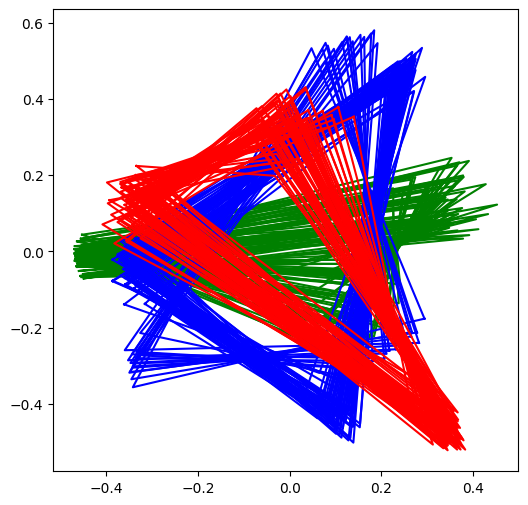

In [59]:
preshape_triangle_2d = PreShapeSpace(3,2)
preshape_triangle_2d.equip_with_group_action("rotations")
preshape_triangle_2d.equip_with_quotient_structure()

T1_aligned=[]

plt.figure(figsize=(6,6))

for i,t in enumerate(T1):
    # plt.subplot(1,3,gmm1.labels_[i]+1)
    T1_aligned.append(preshape_triangle_2d.fiber_bundle.align(point=t, base_point=hopf_fibration(np.array([gmm1.means_[gmm1.labels_[i]]]))[0] ))
    plot_triangle(T1_aligned[-1], c= cmap[gmm1.labels_[i]])
        


In [60]:
preshape_triangle_2d = PreShapeSpace(3,2)
preshape_triangle_2d.equip_with_group_action("rotations")
preshape_triangle_2d.equip_with_quotient_structure()


preshape_triangle_2d.fiber_bundle.align(point=t, base_point=T1[0])

array([[-0.26794086, -0.22394591],
       [-0.34099736,  0.1175794 ],
       [ 0.60893822,  0.10636652]])

In [61]:
gmm1.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

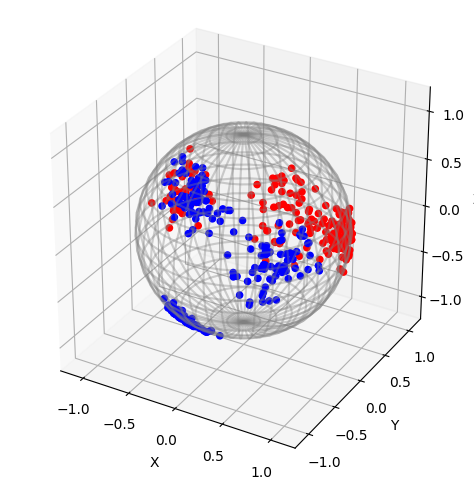

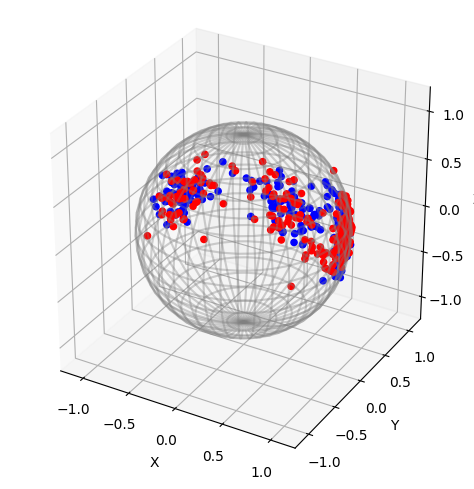

In [62]:
##Weights for gmm00
weights_00 = np.array([25,25,50])/100

##Means for gmm00
m0=np.array([ 1,-.6,.9])
m1=np.array([ -.1,-.3,.3])
m2=np.array([ 1,1,-.3])

means_00 = [m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm00
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,4])/150

covariances_00 = [c0,c1,c2]

X0 = random_wrapped_gaussian_mixture(sphere, means_00, covariances_00, weights_00)


##Weights for gmm01
weights_01 = np.array([33,33,34])/100

##Means for gmm01
m0=np.array([ 1,-1,.3])
m1=np.array([ -.1,-.3,-.3])
m2=np.array([ -.1,-1,.9])

means_01 = [m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm01
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,3])/150

covariances_01 = [c0,c1,c2]

X1 = random_wrapped_gaussian_mixture(sphere, means_01, covariances_01, weights_01)


fig = plt.figure(figsize=(2*6.5,2*6.5))
ax_1 = fig.add_subplot(221, projection='3d')
visualization.plot(X0, ax = ax_1, space="S2", color="red", alpha=1, label="Data points")
visualization.plot(X1, ax = ax_1, space="S2", color="blue", alpha=1, label="Data points")





##Weights for gmm10
weights_10 = np.array([25,25,50])/100

##Means for gmm10
m0=np.array([ 1,-.3,.9])
m1=np.array([ -.1,-1,.3])
m2=np.array([ 1,-.6,-.3])

means_10 = means_00#[m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm10
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,4])/150

covariances_10 = [c0,c1,c2]

X2 = random_wrapped_gaussian_mixture(sphere, means_10, covariances_00, weights_00)


##Weights for gmm11
weights_11 = np.array([33,33,34])/100

##Means for gmm11
m0=np.array([ 1,-.3,.3])
m1=np.array([ -.1,-1,-.3])
m2=np.array([ -.1,-1,.9])

means_11 = means_10

##Covariances for gm11
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,3])/150

covariances_11 = covariances_10

X3 = random_wrapped_gaussian_mixture(sphere, means_11, covariances_11, weights_01)


fig = plt.figure(figsize=(2*6.5,2*6.5))
ax_1 = fig.add_subplot(221, projection='3d')
visualization.plot(X2, ax = ax_1, space="S2", color="red", alpha=1, label="Data points")
visualization.plot(X3, ax = ax_1, space="S2", color="blue", alpha=1, label="Data points")


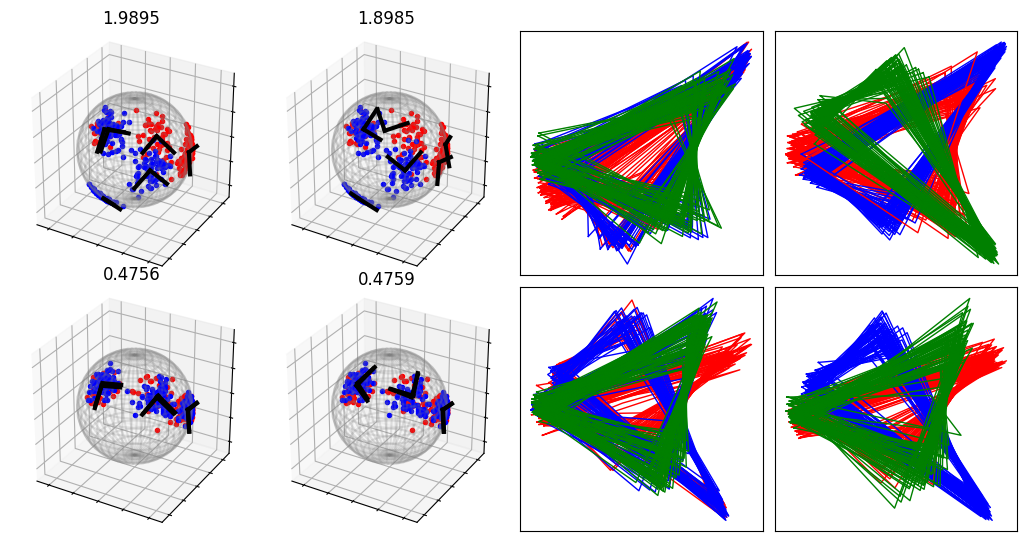

In [96]:
##Weights for gmm00
weights_00 = np.array([25,25,50])/100

##Means for gmm00
m0=np.array([ 1,-.6,.9])
m1=np.array([ -.1,-.3,.3])
m2=np.array([ 1,1,-.3])

means_00 = [m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm00
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,4])/150

covariances_00 = [c0,c1,c2]

X0 = random_wrapped_gaussian_mixture(sphere, means_00, covariances_00, weights_00)


##Weights for gmm01
weights_01 = np.array([33,33,34])/100

##Means for gmm01
m0=np.array([ 1,-1,.3])
m1=np.array([ -.1,-.3,-.3])
m2=np.array([ -.1,-1,.9])

means_01 = [m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm01
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,3])/150

covariances_01 = [c0,c1,c2]

X1 = random_wrapped_gaussian_mixture(sphere, means_01, covariances_01, weights_01)

##Weights for gmm10
weights_10 = np.array([25,25,50])/100

##Means for gmm10
m0=np.array([ 1,-.3,.9])
m1=np.array([ -.1,-1,.3])
m2=np.array([ 1,-.6,-.3])

means_10 = means_00#[m0/np.linalg.norm(m0),m1/np.linalg.norm(m1),m2/np.linalg.norm(m2)]

##Covariances for gmm10
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,4])/150

covariances_10 = [c0,c1,c2]

X2 = random_wrapped_gaussian_mixture(sphere, means_10, covariances_00, weights_00)


##Weights for gmm11
weights_11 = np.array([33,33,34])/100

##Means for gmm11
m0=np.array([ 1,-.3,.3])
m1=np.array([ -.1,-1,-.3])
m2=np.array([ -.1,-1,.9])

means_11 = means_10

##Covariances for gm11
c0=np.diag([2,1])/100
c1=np.diag([1,1])/100
c2=np.diag([1,3])/150

covariances_11 = covariances_10

X3 = random_wrapped_gaussian_mixture(sphere, means_11, covariances_11, weights_01)
















p=np.array([0,0,1])
F = np.array([[0,-1,0],[1,0,0]])

#Define and fit gmm model to X0
gmm0=WrappedGaussianMixture(sphere, n_components=3, reference_point=p, reference_frame=F)
gmm0.fit(X0)

#Define and fit gmm model to X1
gmm1=WrappedGaussianMixture(sphere, n_components=3, reference_point=p, reference_frame=F)
gmm1.fit(X1)

#plot
fig = plt.figure(figsize=(2*6.5,2*3.25))
ax_1 = fig.add_subplot(241,projection='3d')

visualization.plot(p, ax = ax_1, space="S2", color="black", alpha=0.0, label="Data points")
plt.plot(X0[:,0],X0[:,1],X0[:,2],'.',c='red')
plt.plot(X1[:,0],X1[:,1],X1[:,2],'.',c='blue')

for sample_mean in gmm0.means_:
    F_mu_x = sphere.metric.parallel_transport(F,p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)

for sample_mean in gmm1.means_:
    F_mu_x = sphere.metric.parallel_transport(F,p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)
    
    
Pi,M = wasserstein_type_distance(gmm0,gmm1)   

ax_1.set_xlabel(None)
ax_1.set_ylabel(None)
ax_1.set_zlabel(None)
ax_1.set_xticklabels([])
ax_1.set_yticklabels([])
ax_1.set_zticklabels([])
plt.title(round(np.sum(Pi*M),4))
plt.savefig("data_files/images2/experiment_4_0.png", dpi=216, bbox_inches='tight')


#Define and fit gmm model to X0
gmm0=WrappedGaussianMixture(sphere, n_components=3, reference_point=-p, reference_frame=F)
gmm0.fit(X0)


#Define and fit gmm model to X1
gmm1=WrappedGaussianMixture(sphere, n_components=3, reference_point=-p, reference_frame=F)
gmm1.fit(X1)

#plot
# fig = plt.figure(figsize=(6.5,6.5))
ax_2 = fig.add_subplot(242,projection='3d')

visualization.plot(p, ax = ax_2, space="S2", color="black", alpha=0.0, label="Data points")
plt.plot(X0[:,0],X0[:,1],X0[:,2],'.',c='red')
plt.plot(X1[:,0],X1[:,1],X1[:,2],'.',c='blue')

for sample_mean in gmm0.means_:
    F_mu_x = sphere.metric.parallel_transport(F,-p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)

for sample_mean in gmm1.means_:
    F_mu_x = sphere.metric.parallel_transport(F,-p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)
    
ax_2.set_xlabel(None)
ax_2.set_ylabel(None)
ax_2.set_zlabel(None)
ax_2.set_xticklabels([])
ax_2.set_yticklabels([])
ax_2.set_zticklabels([])

Pi,M = wasserstein_type_distance(gmm0,gmm1)    
plt.title(round(np.sum(Pi*M),4))
# plt.savefig("data_files/images2/experiment_4_1.png", dpi=216, bbox_inches='tight')




p=np.array([0,0,1])
F = np.array([[0,-1,0],[1,0,0]])

#Define and fit gmm model to X0
gmm2=WrappedGaussianMixture(sphere, n_components=3, reference_point=p, reference_frame=F)
gmm2.fit(X2)

#Define and fit gmm model to X1
gmm3=WrappedGaussianMixture(sphere, n_components=3, reference_point=p, reference_frame=F)
gmm3.fit(X3)

#plot
# fig = plt.figure(figsize=(6.5,6.5))
ax_3 = fig.add_subplot(245,projection='3d')

visualization.plot(p, ax = ax_3, space="S2", color="black", alpha=0.0, label="Data points")
plt.plot(X2[:,0],X2[:,1],X2[:,2],'.',c='red')
plt.plot(X3[:,0],X3[:,1],X3[:,2],'.',c='blue')

for sample_mean in gmm2.means_:
    F_mu_x = sphere.metric.parallel_transport(F,p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)

for sample_mean in gmm3.means_:
    F_mu_x = sphere.metric.parallel_transport(F,p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)
    
    
Pi,M = wasserstein_type_distance(gmm2,gmm3)   

ax_3.set_xlabel(None)
ax_3.set_ylabel(None)
ax_3.set_zlabel(None)
ax_3.set_xticklabels([])
ax_3.set_yticklabels([])
ax_3.set_zticklabels([])

plt.title(round(np.sum(Pi*M),4))
# plt.savefig("data_files/images2/experiment_4_2.png", dpi=216, bbox_inches='tight')


#Define and fit gmm model to X0
gmm2=WrappedGaussianMixture(sphere, n_components=3, reference_point=-p, reference_frame=F)
gmm2.fit(X2)

#Define and fit gmm model to X1
gmm3=WrappedGaussianMixture(sphere, n_components=3, reference_point=-p, reference_frame=F)
gmm3.fit(X3)

#plot
# fig = plt.figure(figsize=(6.5,6.5))
ax_4 = fig.add_subplot(246,projection='3d')

visualization.plot(p, ax = ax_4, space="S2", color="black", alpha=0.0, label="Data points")
plt.plot(X2[:,0],X2[:,1],X2[:,2],'.',c='red')
plt.plot(X3[:,0],X3[:,1],X3[:,2],'.',c='blue')

for sample_mean in gmm2.means_:
    F_mu_x = sphere.metric.parallel_transport(F,-p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)

for sample_mean in gmm3.means_:
    F_mu_x = sphere.metric.parallel_transport(F,-p,end_point=sample_mean)
    plot_tangent_vecs(sample_mean,F_mu_x, cmap=['black']*2,linewidth=3,zorder=100)
    
ax_4.set_xlabel(None)
ax_4.set_ylabel(None)
ax_4.set_zlabel(None)
ax_4.set_xticklabels([])
ax_4.set_yticklabels([])
ax_4.set_zticklabels([])
# ax_4.tick_params(axis='both', which='major', labelsize=8)

Pi,M = wasserstein_type_distance(gmm2,gmm3)    
ax_4.set_title(round(np.sum(Pi*M),4),pad=0)


# plt.subplots_adjust(wspace=0, hspace=.05)

# plt.show()
# plt.savefig("data_files/images2/experiment_4_3.png", dpi=216, bbox_inches='tight')




# fig = plt.figure(figsize=(6.5,6.5))
plt.subplot(2,4,3)

T0 = hopf_fibration(X0, center=True)
T0_aligned=[]
T1_aligned=[]
# for i,t in enumerate(T0):
#         plot_triangle(t, c = cmap[gmm0.labels_[i]])
#         plt.xticks([])
#         plt.yticks([])
for i,t in enumerate(T0):
    # plt.subplot(1,3,gmm1.labels_[i]+1)
    T0_aligned.append(preshape_triangle_2d.fiber_bundle.align(point=t, base_point=hopf_fibration(np.array([gmm0.means_[gmm0.labels_[i]]]))[0] ))
    plot_triangle(T0_aligned[-1], c= cmap[gmm1.labels_[i]], linewidth=1)
        
plt.xticks([])
plt.yticks([])
        
# plt.savefig("data_files/images2/experiment_4_X0.png", dpi=216, bbox_inches='tight')



# fig = plt.figure(figsize=(6.5,6.5))
plt.subplot(2,4,4)

T1 = hopf_fibration(X1, center=True)
# for i,t in enumerate(T1):
#         plot_triangle(t, c = cmap[gmm1.labels_[i]])
#         plt.xticks([])
#         plt.yticks([])
for i,t in enumerate(T1):
    # plt.subplot(1,3,gmm1.labels_[i]+1)
    T1_aligned.append(preshape_triangle_2d.fiber_bundle.align(point=t, base_point=hopf_fibration(np.array([gmm1.means_[gmm1.labels_[i]]]))[0] ))
    plot_triangle(T1_aligned[-1], c= cmap[gmm1.labels_[i]], linewidth=1)
        
plt.xticks([])
plt.yticks([])
        
# plt.savefig("data_files/images2/experiment_4_X1.png", dpi=216, bbox_inches='tight')



# fig = plt.figure(figsize=(6.5,6.5))
plt.subplot(2,4,7)
T0_aligned=[]
T1_aligned=[]
T0 = hopf_fibration(X2, center=True)
# for i,t in enumerate(T0):
#         plot_triangle(t, c = cmap[gmm0.labels_[i]])
#         plt.xticks([])
#         plt.yticks([])
for i,t in enumerate(T0):
    # plt.subplot(1,3,gmm1.labels_[i]+1)
    T0_aligned.append(preshape_triangle_2d.fiber_bundle.align(point=t, base_point=hopf_fibration(np.array([gmm2.means_[gmm2.labels_[i]]]))[0] ))
    plot_triangle(T0_aligned[-1], c= cmap[gmm1.labels_[i]], linewidth=1)
        
plt.xticks([])
plt.yticks([])
        
# plt.savefig("data_files/images2/experiment_4_X2.png", dpi=216, bbox_inches='tight')



# fig = plt.figure(figsize=(6.5,6.5))
plt.subplot(2,4,8)

T1 = hopf_fibration(X3, center=True)
# for i,t in enumerate(T1):
#         plot_triangle(t, c = cmap[gmm1.labels_[i]])
#         plt.xticks([])
#         plt.yticks([])
for i,t in enumerate(T1):
    # plt.subplot(1,3,gmm1.labels_[i]+1)
    T1_aligned.append(preshape_triangle_2d.fiber_bundle.align(point=t, base_point=hopf_fibration(np.array([gmm3.means_[gmm3.labels_[i]]]))[0] ))
    plot_triangle(T1_aligned[-1], c= cmap[gmm1.labels_[i]], linewidth=1)
        
plt.xticks([])
plt.yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0.05)



plt.savefig("data_files/images2/experiment_4_full.png", dpi=216, bbox_inches='tight')